In [1]:
from autograd import grad
import autograd.numpy as np
import matplotlib.pyplot as plt
from lista import LISTA, make_loss
from functions import *
from copy import deepcopy
import cvxpy as cvx
from itertools import permutations
import pandas as pd

In [2]:
def obj_func(W, D):
    """Cost function to minimize to obtain the analytic weights

    Parameters
    ----------
    D : ndarray, shape (n_atoms, n_dim)
        Dictionary for the considered sparse coding problem.
    """
    n_atoms, n_dim = D.shape
    Ik = np.eye(n_atoms)
    WtD = W.dot(D.T) - Ik
    Q = np.ones((n_atoms, n_atoms)) - Ik
    WtD *= np.sqrt(Q)
    return np.sum(WtD * WtD)


def proj(W, D):
    """Projection for W on the constraint set s.t. W_i^TD_i = 1
    """
    aw = np.diag(W.dot(D.T))
    return W + (1-aw)[:, None] * D


def get_alista_weights(D, max_iter=10000, step_size=1e-2, tol=1e-12):
    """Cost function to minimize to obtain the analytic weights

    Parameters
    ----------
    D : ndarray, shape (n_atoms, n_dim)
        Dictionary for the considered sparse coding problem.
    """
    n_atoms, n_dim = D.shape
    W = np.copy(D)
    pobj = [obj_func(W, D)]
    for i in range(max_iter):
        res = W.dot(D.T) - np.eye(n_atoms)
        grad = res.dot(D)
        W -= step_size * grad

        W = proj(W, D)

        pobj.append(obj_func(W, D))
        assert pobj[-1] <= pobj[-2]
        if 1 - pobj[-1] / pobj[-2] < tol:
            break

    assert np.allclose(np.diag(W.dot(D.T)), 1)
    return W

In [9]:
layers = np.linspace(1, 9, 5, dtype=int)

rng = np.random.RandomState(2)
n_samples = 100
n_test = 1000
k = 2
p = 5
K = np.random.randn(p, p)
fit_loss = 'l2'
reg = 'l1'
architecture = 'pgd'



fit_function, der_function = {
                              'l2': (l2_fit, l2_der),
                              'logreg': (logreg_fit, logreg_der)
                              }[fit_loss]
reg_function, prox = {
                      'l2': (l2_pen, l2_prox),
                      'l1': (l1_pen, l1_prox),
                      None: (no_pen, no_prox)
                      }[reg]
loss = make_loss(fit_function, reg_function)

z_true = rng.randn(p, n_samples)
D = rng.randn(k, p)
# D /= np.linalg.norm(D, axis=0, keepdims=True)

sigma = 0.1
eps = rng.randn(k, n_samples)

z_test = rng.randn(p, n_test)
eps_test = rng.randn(k, n_test)
X = np.dot(D, z_true) + eps
X_test = np.dot(D, z_test) + eps_test
if fit_loss == 'logreg':
    X = 2 * (X > 0) - 1
    X_test = 2 * (X_test > 0) - 1

X_train = np.random.randn(k, n_samples)
X_train /= np.max(np.abs(np.dot(D.T, X_train)), axis=0)
X_test /= np.max(np.abs(np.dot(D.T, X_test)), axis=0)
lbda = 0.8
print('lambda = %.2e' % lbda)

lambda = 8.00e-01


In [10]:
def loss_lasso(z, x, D, lbda):
    res = D.dot(z) - x
    return .5 * np.sum(res ** 2, axis=0) + lbda * np.sum(np.abs(z), axis=0)

In [11]:
def upperbound_spca(B, k, verbose=False):
    n_dim = B.shape[0]
    X = cvx.Variable((n_dim, n_dim))
    pb = cvx.Problem(cvx.Maximize(cvx.trace(X * B)),
                     [cvx.constraints.PSD(X),
                      cvx.constraints.Zero(cvx.trace(X) - 1),
                      cvx.constraints.NonPos(
                          cvx.sum(cvx.abs(X)) - k
                     )])
    pb.solve(verbose=verbose, max_iters=10000)
    return pb.value

4.9456354792602635e-16
13.548637238359737


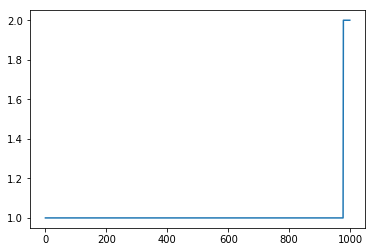

In [12]:
ista = LISTA(D, lbda, 10000, fit_loss, reg)
L = ista.L
z_hat = ista.transform(X_test)
f_min = loss_lasso(z_hat, X_test, D, lbda)

print(np.linalg.norm(z_hat - prox(z_hat - np.dot(D.T / L, der_function(np.dot(D, z_hat), X_test)), lbda / L)))
print(L)
spar = np.sum(z_hat != 0, axis=0)
plt.plot(np.sort(spar))

In [13]:
z_hat = LISTA(D, lbda, 50, fit_loss, reg).transform(X_train)
sup = z_hat != 0
spar = np.sum(sup, axis=0)
x_train = X_train[:, spar == 1]
print(x_train.shape)
eig = []
for sup in sup.T:
    d = D[:, sup]
    eig.append(np.linalg.eigvalsh(d.T.dot(d))[-1])
eig = np.array(eig)

(2, 91)


In [22]:
n_layers = 20
lista_one_one = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, variables='W1', n_layers_learn=0,
                      one_level_each=True)
lista_one_one.fit(X_train,l_rate=0.05, max_iter=1001, backtrack=True, verbose=10, thres=0, l_rate_min=1e-10)

it 0, loss = 3.366e-01, grad_W = 4.10e-03, grad_l = 3.01e-03, , l_rate = 5.00e-02
it 10, loss = 3.365e-01, grad_W = 4.04e-03, grad_l = 2.29e-03, , l_rate = 5.12e+01
it 20, loss = 3.364e-01, grad_W = 6.62e-03, grad_l = 8.14e-05, , l_rate = 1.02e+02
it 30, loss = 3.364e-01, grad_W = 6.69e-03, grad_l = 7.75e-05, , l_rate = 1.02e+02
it 40, loss = 3.364e-01, grad_W = 7.29e-03, grad_l = 1.21e-04, , l_rate = 1.02e+02
it 50, loss = 3.364e-01, grad_W = 9.98e-03, grad_l = 1.65e-04, , l_rate = 1.02e+02
it 60, loss = 3.364e-01, grad_W = 7.40e-03, grad_l = 7.20e-04, , l_rate = 6.40e+00
it 70, loss = 3.364e-01, grad_W = 7.61e-03, grad_l = 7.45e-04, , l_rate = 3.20e+00
it 80, loss = 3.364e-01, grad_W = 5.98e-03, grad_l = 6.91e-04, , l_rate = 3.20e+00
it 90, loss = 3.364e-01, grad_W = 1.02e-02, grad_l = 8.61e-04, , l_rate = 3.20e+00
it 100, loss = 3.364e-01, grad_W = 8.65e-03, grad_l = 8.10e-04, , l_rate = 1.60e+00


In [23]:
lista_one_one.weights[0] - D.T

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [24]:
lista_one_one.levels[:, 0]

array([0.22816356, 0.07388812, 0.16760042, 0.15555006, 0.15971999,
       0.15971991, 0.16033997, 0.16028033, 0.16189387, 0.16191278,
       0.16526418, 0.16530606, 0.16707144, 0.16718458, 0.16805166,
       0.16806604, 0.16826555, 0.16827948, 0.16823502, 0.16851401])

In [21]:
1 / Ld

0.0738081611018958

In [90]:
lista_zero = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, variables='W1', n_layers_learn=0,
                      one_level_each=True)
for i in range(0, n_layers):
    lista_zero.weights[2 * i] = D.T
    lista_zero.levels[i]  = 1 / L
lista_zero.fit(X_train,l_rate=0.05, max_iter=101, backtrack=True, verbose=10, thres=0, l_rate_min=1e-10)

it 0, loss = 3.557e-02, grad_W = 3.36e-03, grad_l = 3.51e-02, , l_rate = 5.00e-02
it 10, loss = 3.492e-02, grad_W = 1.73e-03, grad_l = 6.24e-03, , l_rate = 5.12e+01
it 20, loss = 3.487e-02, grad_W = 1.58e-03, grad_l = 4.55e-03, , l_rate = 3.20e+00
it 30, loss = 3.487e-02, grad_W = 1.93e-03, grad_l = 4.54e-03, , l_rate = 1.60e+00
it 40, loss = 3.486e-02, grad_W = 1.92e-03, grad_l = 3.87e-03, , l_rate = 1.60e+00
it 50, loss = 3.486e-02, grad_W = 2.60e-03, grad_l = 9.47e-03, , l_rate = 1.60e+00
it 60, loss = 3.486e-02, grad_W = 1.53e-03, grad_l = 4.10e-03, , l_rate = 4.00e-01
it 70, loss = 3.486e-02, grad_W = 1.58e-03, grad_l = 3.51e-03, , l_rate = 8.00e-01
it 80, loss = 3.485e-02, grad_W = 1.51e-03, grad_l = 4.06e-03, , l_rate = 1.60e+00
it 90, loss = 3.485e-02, grad_W = 2.49e-03, grad_l = 5.84e-03, , l_rate = 1.60e+00
it 100, loss = 3.485e-02, grad_W = 1.73e-03, grad_l = 2.82e-03, , l_rate = 8.00e-01


In [91]:
ista = LISTA(D, lbda, n_layers, fit_loss, reg)
algos = [lista_zero, lista_one_one,  ista, ]
algos_names = ['zero', 'one', 'ista']
spar = {}
ident = {}
for algo in algos:
    spar[algo] = []
    ident[algo] = []

    z_f = algo.transform(X_train)
    s_f = z_f != 0
    for i in range(1, n_layers):
        z = algo.transform(X_train, layer=i)
        supp = z != 0
        spar[algo].append(np.sum(supp, axis=0))
        ident[algo].append(np.sum(np.bitwise_xor(supp, s_f), axis=0))
    ident[algo] = np.array(ident[algo])
    spar[algo] = np.array(spar[algo])

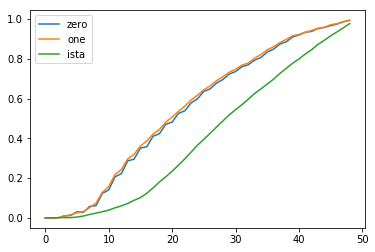

In [92]:
for algo, names in zip(algos, algos_names):
    plt.plot(np.mean(ident[algo] == 0, axis=1), label = names)
plt.legend()

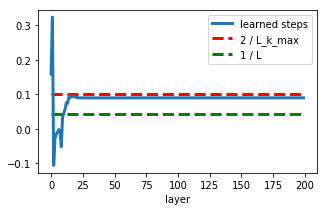

In [102]:
plt.figure(figsize=(5, 3))
plt.plot(lista_one_one.levels[:, 0], label = 'learned steps', linewidth=3)
plt.hlines(2 / eig.max(), 0, n_layers, linestyles='--',  color='r', label = '2 / L_k_max', linewidth=3)
plt.hlines(1 / L, 0, n_layers, linestyles='--', color='g', label= '1 / L', linewidth=3)
plt.xlabel('layer')
plt.legend()

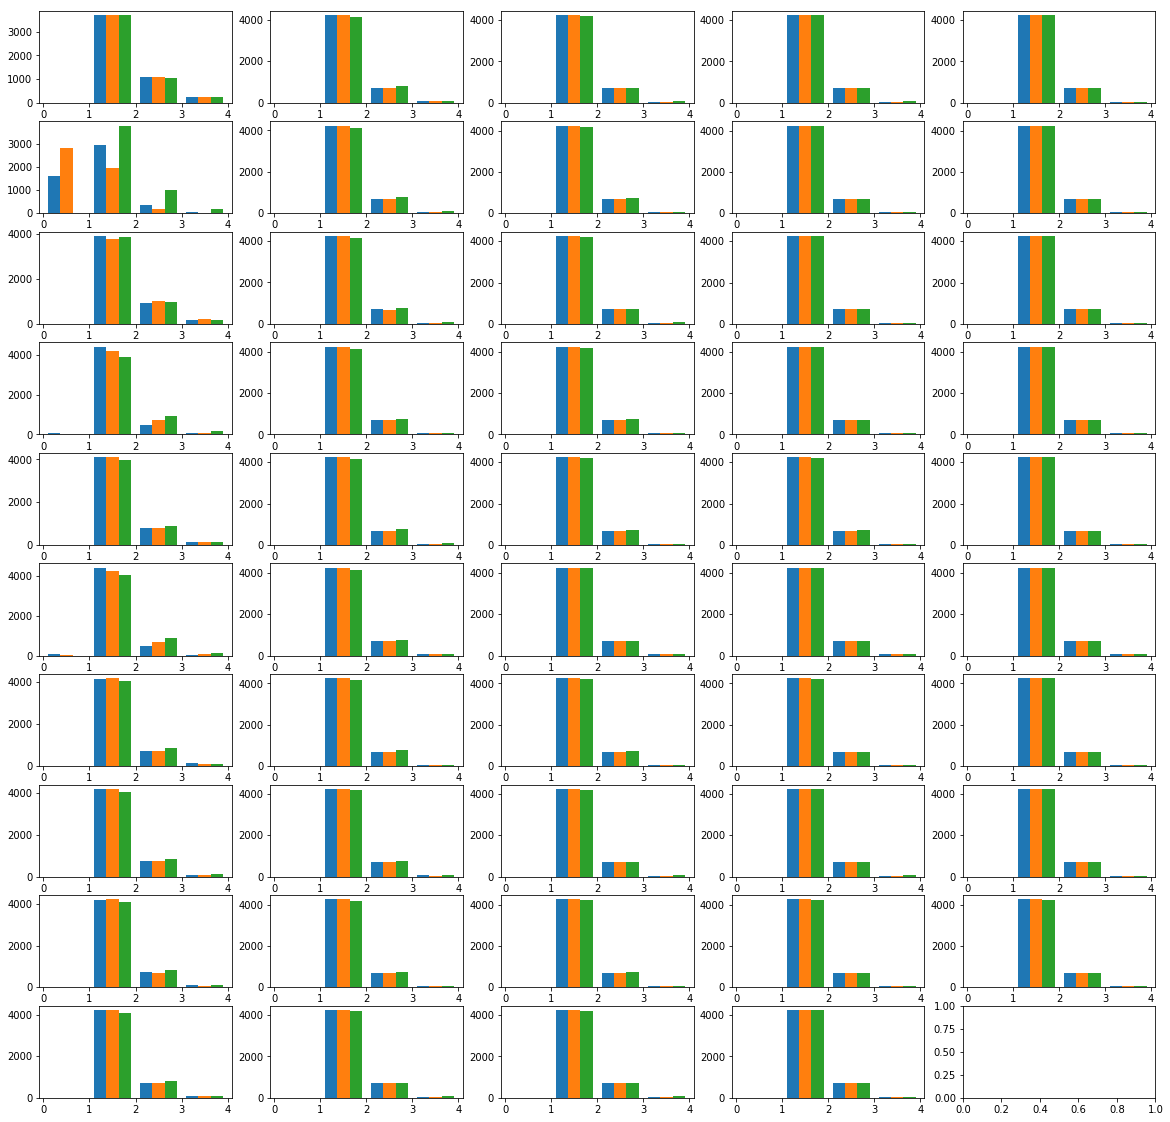

In [45]:
f, ax = plt.subplots(n_layers // 5, 5, figsize=(20, 20))
for i, axe in enumerate(ax.T.ravel()[:-1]):
    axe.hist([spar[algo][i] for algo in algos], bins=range(5))

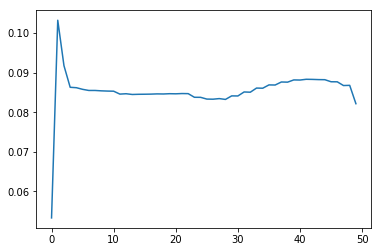

In [30]:
plt.plot(lista_one_one.levels[:, 0])

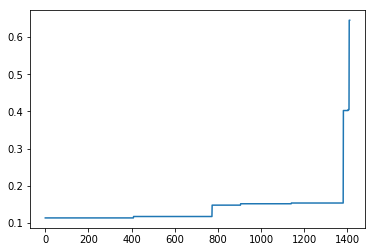

In [159]:
plt.plot(np.sort(1 / eig[spar==1]))

In [107]:
n_layers = 50

In [73]:

lista_zero = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, variables='W1', n_layers_learn=0)
for i in range(0, n_layers):
    lista_zero.weights[2 * i] = D.T
    lista_zero.levels[i]  = 1 / L
lista_zero.fit(X_train,l_rate=0.05, max_iter=101, backtrack=True, verbose=100, thres=0, l_rate_min=1e-10)

it 0, loss = 5.954e-01, grad_W = 3.16e-03, grad_l = 1.59e-03, , l_rate = 5.00e-02
it 100, loss = 5.951e-01, grad_W = 2.74e-04, grad_l = 1.65e-05, , l_rate = 1.31e+04


In [74]:
lista_one = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, variables='W1', n_layers_learn=1)
for i in range(0, n_layers):
    lista_one.weights[2 * i] = D.T
    lista_one.levels[i]  = 1 / L
lista_one.fit(X_train,l_rate=0.05, max_iter=101, backtrack=True, verbose=100, thres=0, l_rate_min=1e-10)

it 0, loss = 5.954e-01, grad_W = 3.16e-03, grad_l = 1.59e-03, , l_rate = 5.00e-02
it 100, loss = 5.951e-01, grad_W = 2.80e-04, grad_l = 2.90e-05, , l_rate = 3.28e+03


In [108]:
lista_one_one = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, variables='W1', n_layers_learn=1,
                      one_level_each=True)
for i in range(0, n_layers):
    lista_one_one.weights[2 * i] = D.T
    lista_one_one.levels[i]  = 1 / L
lista_one_one.fit(X_train,l_rate=0.05, max_iter=101, backtrack=True, verbose=10, thres=0, l_rate_min=1e-10)

it 0, loss = 5.920e-02, grad_W = 8.14e-05, grad_l = 3.92e-02, , l_rate = 5.00e-02
it 10, loss = 5.909e-02, grad_W = 3.45e-05, grad_l = 1.58e-03, , l_rate = 5.12e+01
it 20, loss = 5.908e-02, grad_W = 4.20e-05, grad_l = 1.22e-03, , l_rate = 2.56e+01
it 30, loss = 5.908e-02, grad_W = 1.86e-05, grad_l = 2.89e-04, , l_rate = 3.20e+00
it 40, loss = 5.908e-02, grad_W = 2.30e-05, grad_l = 3.25e-04, , l_rate = 2.56e+01
it 50, loss = 5.908e-02, grad_W = 1.91e-05, grad_l = 1.66e-04, , l_rate = 3.20e+00
it 60, loss = 5.908e-02, grad_W = 1.81e-05, grad_l = 2.38e-04, , l_rate = 4.00e-01
it 70, loss = 5.908e-02, grad_W = 1.81e-05, grad_l = 2.19e-04, , l_rate = 1.60e+00
it 80, loss = 5.908e-02, grad_W = 2.42e-05, grad_l = 3.35e-04, , l_rate = 3.20e+00
it 90, loss = 5.908e-02, grad_W = 2.78e-05, grad_l = 4.48e-04, , l_rate = 3.20e+00
it 100, loss = 5.908e-02, grad_W = 2.86e-05, grad_l = 4.75e-04, , l_rate = 3.20e+00


In [109]:
steps = lista_one_one.levels[:, 0]

In [110]:
z_ = lista_one_one.transform(X_train)
s = z_ != 0
spar = np.sum(s, axis=0)

eig = []
for sup in s.T:
    d = D[:, sup]
    eig.append(np.linalg.eigvalsh(d.T.dot(d))[-1])
eig = np.array(eig)

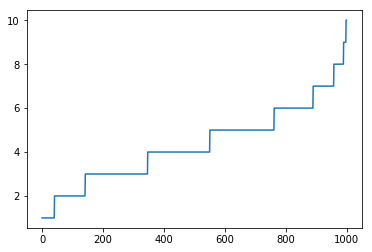

In [111]:
plt.plot(np.sort(spar))

(array([19., 31., 47., 47., 29., 18.,  8.,  2.,  2.,  1.]),
 array([18.92711237, 21.94438151, 24.96165064, 27.97891977, 30.99618891,
        34.01345804, 37.03072718, 40.04799631, 43.06526544, 46.08253458,
        49.09980371]),
 <a list of 10 Patch objects>)

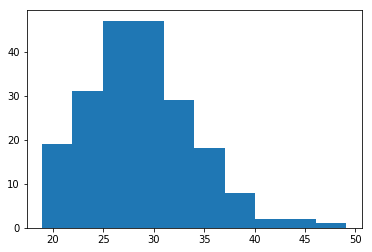

In [112]:
plt.hist(eig[spar==4])

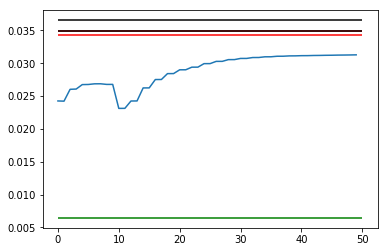

In [121]:
plt.plot(steps)
plt.hlines(1 / np.mean(eig), 0, n_layers, color='r')
plt.hlines(np.mean(1 / eig), 0, n_layers, color='k')
plt.hlines(1 / np.median(eig), 0, n_layers, color='r')
plt.hlines(np.median(1 / eig), 0, n_layers, color='k')
plt.hlines(1 / L, 0, n_layers, color='g')
#plt.hlines(1 / eig, 0, n_layers)

In [75]:
lista_two = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, variables='W1', n_layers_learn=2)
for i in range(0, n_layers):
    lista_two.weights[2 * i] = D.T
    lista_two.levels[i]  = 1 / L
lista_two.fit(X_train,l_rate=0.05, max_iter=101, backtrack=True, verbose=100, thres=0, l_rate_min=1e-10)

it 0, loss = 5.954e-01, grad_W = 3.16e-03, grad_l = 1.59e-03, , l_rate = 5.00e-02
it 100, loss = 5.951e-01, grad_W = 2.77e-04, grad_l = 2.87e-05, , l_rate = 6.55e+03


In [76]:
alista = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, learn_steps=True, n_layers_learn=-1)
for i in range(n_layers):
    alista.weights[2 * i] = W_alista.T
alista.fit(X_train,l_rate=0.05, max_iter=101, backtrack=True, verbose=100, thres=0, l_rate_min=1e-10)

it 0, loss = 6.270e-01, grad_W = 1.12e-01, grad_l = 1.34e-02, , l_rate = 5.00e-02
it 100, loss = 6.066e-01, grad_W = 2.74e-02, grad_l = 3.58e-03, , l_rate = 7.45e-10


In [77]:
layers = range(1, n_layers + 1)
for n_layers in layers:
    print(n_layers)
    ista = LISTA(D, lbda, n_layers, fit_loss, reg)
    lista = LISTA(D, lbda, n_layers, fit_loss, reg, learn_levels=True, variables='W1')
    if n_layers > 1:
        lista.weights[:len(old_weights)] = old_weights
        lista.levels[:len(old_levels)] = old_levels
    lista.fit(X_train,l_rate=0.05, max_iter=101, backtrack=True, verbose=100, thres=0, l_rate_min=1e-10)
    old_weights = deepcopy(lista.weights)
    old_levels = deepcopy(lista.levels)

1
it 0, loss = 6.621e-01, grad_W = 2.57e-02, grad_l = 7.42e-02, , l_rate = 5.00e-02
it 100, loss = 6.117e-01, grad_W = 3.41e-03, grad_l = 3.03e-03, , l_rate = 3.20e+00
2
it 0, loss = 6.074e-01, grad_W = 6.66e-03, grad_l = 7.68e-03, , l_rate = 5.00e-02
it 100, loss = 6.013e-01, grad_W = 2.13e-03, grad_l = 1.09e-03, , l_rate = 6.40e+00
3
it 0, loss = 6.003e-01, grad_W = 2.80e-03, grad_l = 2.80e-03, , l_rate = 5.00e-02
it 100, loss = 5.982e-01, grad_W = 3.20e-03, grad_l = 9.71e-04, , l_rate = 2.56e+01
4
it 0, loss = 5.978e-01, grad_W = 2.29e-03, grad_l = 1.52e-03, , l_rate = 5.00e-02
it 100, loss = 5.970e-01, grad_W = 1.67e-03, grad_l = 8.77e-04, , l_rate = 1.28e+01
5
it 0, loss = 5.968e-01, grad_W = 2.51e-03, grad_l = 1.08e-03, , l_rate = 5.00e-02
it 100, loss = 5.965e-01, grad_W = 1.72e-03, grad_l = 7.91e-04, , l_rate = 1.28e+01
6
it 0, loss = 5.963e-01, grad_W = 1.68e-03, grad_l = 8.90e-04, , l_rate = 5.00e-02
it 100, loss = 5.961e-01, grad_W = 1.51e-03, grad_l = 7.00e-04, , l_rate = 1

it 100, loss = 5.951e-01, grad_W = 2.18e-04, grad_l = 6.61e-05, , l_rate = 3.20e+00


In [78]:
networks = [ista, lista, lista_zero, lista_one, lista_one_one, lista_two, alista]
names = ['ista', 'lista', 'zero', 'one', 'one_one', 'two', 'alista']
losses = {}
supports = {}
sparsities = {}
for name in names:
    losses[name] = []
    supports[name] = []
    sparsities[name] = []
for network, name in zip(networks, names):
    support = np.ones((p, n_test))
    for i in range(n_layers):
        z = network.forward(X_test, network.weights, network.p, i,
                            network.levels, network.steps, network.der_function, network.prox, lbda)
        new_support = z != 0
        supports[name].append(np.sum(np.logical_xor(new_support, support), axis=0))
        support = new_support
        losses[name].append(loss_lasso(z, X_test, D, lbda))
        sparsities[name].append(np.mean(new_support, axis=0))
for name in names:
    losses[name] = np.array(losses[name])
    supports[name] = np.array(supports[name])
    sparsities[name] = np.array(sparsities[name])

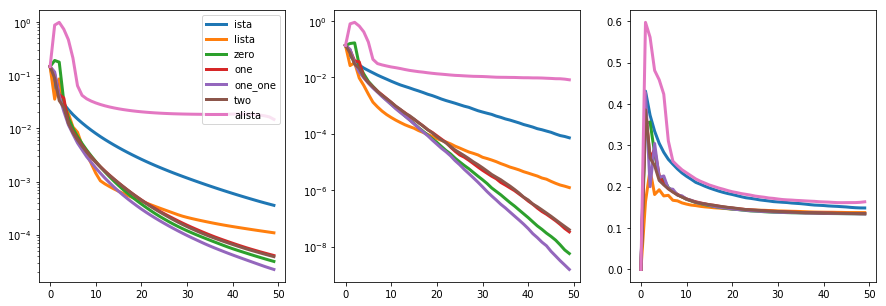

In [79]:
f, ax = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
sparsity = np.sum(z_hat != 0, axis=0)
for i, name in enumerate(names):
    ax[0].semilogy(np.mean((losses[name] - f_min), axis=1), label=name, linewidth=3, c=f'C{i}')
    ax[1].semilogy(np.median((losses[name] - f_min), axis=1), label=name, linewidth=3, c=f'C{i}')
    ax[2].plot(np.mean(sparsities[name], axis=1), c=f'C{i}', linewidth=3)
ax[0].legend()